In [160]:

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

if torch.cuda.is_available():
    print("Yeah we have a GPU!")
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

import torchvision
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import os

import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

import itertools

from gdeep.decision_boundary import GradientFlowDecisionBoundaryCalculator

In [161]:
# https://github.com/L1aoXingyu/pytorch-beginner/blob/master/08-AutoEncoder/conv_autoencoder.py


if not os.path.exists('/home/reinauer/EPFL/giotto-deep/examples/mlp_img'):
    os.mkdir('/home/reinauer/EPFL/giotto-deep/examples/mlp_img')


def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x


num_epochs = 100
batch_size = 128
learning_rate = 1e-3

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = MNIST('./data', transform=img_transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
            nn.ReLU(True),
            nn.Linear(12, 3))
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), nn.Linear(128, 28 * 28), nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


model_auto = autoencoder().to(dev)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model_auto.parameters(), lr=learning_rate, weight_decay=1e-5)

In [162]:
model_auto = torch.load('/home/reinauer/EPFL/giotto-deep/examples/sim_autoencoder.pth')
model_auto.eval()

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Tanh()
  )
)

In [164]:
# https://github.com/pytorch/examples/blob/master/mnist/main.py
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR


transform=transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.1307,), (0.3081,))
    ])

batch_size = 64
test_batch_size = 64
train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}

dataset1 = datasets.MNIST('./data', train=True, download=True,
                    transform=transform)
dataset2 = datasets.MNIST('./data', train=False,
                    transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


def train(log_interval, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [165]:
model = torch.load('/home/reinauer/EPFL/giotto-deep/examples/cnn_minst_10.pth')
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [166]:
class LambdaLayer(nn.Module):
    def __init__(self, lam):
        super().__init__()
        self.lam = lam
    def forward(self, x):
        return self.lam(x)

class DBMulticlass(nn.Module):
    def forward(self, x):
        y = torch.topk(x, 2).values
        return (y[:, 0] - y[:, 1])**2

embedding_model = nn.Sequential(model_auto.decoder,
                    LambdaLayer(lambda x: x.reshape(-1, 1, 28, 28)),
                    model,
                    DBMulticlass())

In [167]:
embedding_model_multi = nn.Sequential(model_auto.decoder,
                    LambdaLayer(lambda x: x.reshape(-1, 1, 28, 28)),
                    model)

In [219]:
db_sample_df = pd.read_csv('EPFL/giotto-deep/examples/MNIST_3D/computed_points_1M.csv')

In [169]:
fig = px.scatter_3d(db_sample_df, x='x0', y='x1', z='x2')
fig.show()

In [221]:
def generate_mesh_input_batch(db_sample_df):
    min_idx = db_sample_df.index.min()
    db_tensor = torch.tensor(db_sample_df.values)[:,1:]
    db_tensor = db_tensor.type(torch.float32)


    db_tensor_logit = embedding_model_multi(db_tensor)
    max_top2 = torch.topk(db_tensor_logit, 2).indices.max(axis=1)
    db_class = {}
    for digit_class in range(10):
        db_class[digit_class] = {}
        db_class[digit_class]['tensor'] = max_top2.values == digit_class
        db_class[digit_class]['idx'] = torch.nonzero(db_class[digit_class]['tensor']) + min_idx

    db_sample_class_df = pd.DataFrame(columns=['class'])
    


    for digit_class in range(10):
        db_sample_class_df = db_sample_class_df.append(pd.DataFrame(db_class[digit_class]['idx'][:,0].shape[0]*[digit_class], columns=['class'], index=db_class[digit_class]['idx'][:,0].numpy()))
    
    db_sample_normal_df = pd.DataFrame(columns = ["dx"+str(i) for i in range(3)])

    for digit_class in range(10):
        x = db_tensor[db_class[digit_class]['tensor']]
        if x.shape[0] != 0:
            x.requires_grad = False
            delta = torch.zeros_like(x, requires_grad=True)
            loss = torch.sum(embedding_model_multi(x + delta)[:, digit_class])
            loss.backward()
            x_gradient = delta.grad.detach().numpy()
            x_norm = x_gradient/np.sqrt((x_gradient**2).sum(axis=1, keepdims=True))

            db_sample_normal_df = db_sample_normal_df.append(
                pd.DataFrame(data=x_norm,
                    columns = ["dx"+str(i) for i in range(3)],
                    index=db_class[digit_class]['idx'].numpy()[:,0])
            )


    return pd.concat([db_sample_df[['x0', 'x1', 'x2']], db_sample_normal_df, db_sample_class_df], axis=1, join='inner')

In [222]:
def generate_mesh_input(db_sample_df, batch_size=100, verbose=False):
    def create_generator_df(batch_size, df):
        n_batches = int(df.shape[0]/batch_size)
        if verbose:
            print('Number of batches:', n_batches)
        for i in range(n_batches):
            yield df[i*batch_size:(i+1)*batch_size]

    gen = create_generator_df(batch_size, db_sample_df)


    for i, batch_db in enumerate(gen):
        if i == 0:
            point_cloud = generate_mesh_input_batch(batch_db)
        else:
            point_cloud = point_cloud.append(generate_mesh_input_batch(batch_db), ignore_index=True)
        if verbose and i % 100 == 0:
            print('Batch number', i)
    return point_cloud

In [223]:
point_cloud = generate_mesh_input(db_sample_df, verbose=True)

Number of batches: 8885
Batch number 0
<ipython-input-221-278548eee135>:32: RuntimeWarning:

invalid value encountered in true_divide

Batch number 100
Batch number 200
Batch number 300
Batch number 400
Batch number 500
Batch number 600
Batch number 700
Batch number 800
Batch number 900
Batch number 1000
Batch number 1100
Batch number 1200
Batch number 1300
Batch number 1400
Batch number 1500
Batch number 1600
Batch number 1700
Batch number 1800
Batch number 1900
Batch number 2000
Batch number 2100
Batch number 2200
Batch number 2300
Batch number 2400
Batch number 2500
Batch number 2600
Batch number 2700
Batch number 2800
Batch number 2900
Batch number 3000
Batch number 3100
Batch number 3200
Batch number 3300
Batch number 3400
Batch number 3500
Batch number 3600
Batch number 3700
Batch number 3800
Batch number 3900
Batch number 4000
Batch number 4100
Batch number 4200
Batch number 4300
Batch number 4400
Batch number 4500
Batch number 4600
Batch number 4700
Batch number 4800
Batch numb

In [227]:
point_cloud.to_csv('/home/reinauer/EPFL/giotto-deep/examples/MNIST_3D/mesh_input_900k.csv')

In [228]:

#libraries used
import numpy as np
import pandas as pd
import open3d as o3d

In [257]:
dataname="/home/reinauer/EPFL/giotto-deep/examples/MNIST_3D/mesh_input_900k.csv"
point_cloud = pd.read_csv(dataname).values#[:, 1:-1]

In [258]:
point_cloud

array([[ 0.0000000e+00, -1.5795748e+01, -1.9551004e+01, ...,
        -6.2749800e-01,  7.5885177e-01,  7.0000000e+00],
       [ 1.0000000e+00,  5.6684732e+00, -1.0797004e+01, ...,
        -4.4757354e-01,  1.9657594e-01,  7.0000000e+00],
       [ 2.0000000e+00, -1.0613920e+01, -1.5438825e+01, ...,
         6.7604070e-01,  3.4500050e-01,  7.0000000e+00],
       ...,
       [ 8.8849700e+05,  1.3491585e+01,  3.3864760e+01, ...,
         6.0969630e-01,  4.1510916e-01,  6.0000000e+00],
       [ 8.8849800e+05,  1.7423025e+01,  2.5455198e+01, ...,
         1.4323570e-01,  7.7739304e-01,  5.0000000e+00],
       [ 8.8849900e+05, -5.6397133e+00,  2.3495913e+01, ...,
        -6.9811374e-01, -6.9066320e-01,  6.0000000e+00]])

In [234]:
np.sum(np.sqrt(np.sum(point_cloud[:,3:6]**2, axis=1)) < 100.)

1653

In [249]:
reasonable_pts_idxs = np.sqrt(np.sum(point_cloud[:,:3]**2, axis=1)) < 100.

In [250]:
reasonable_pts_idxs.shape

(888500,)

In [251]:
#Format to open3d usable objects
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_cloud[reasonable_pts_idxs,:3])
pcd.normals = o3d.utility.Vector3dVector(point_cloud[reasonable_pts_idxs,3:6])

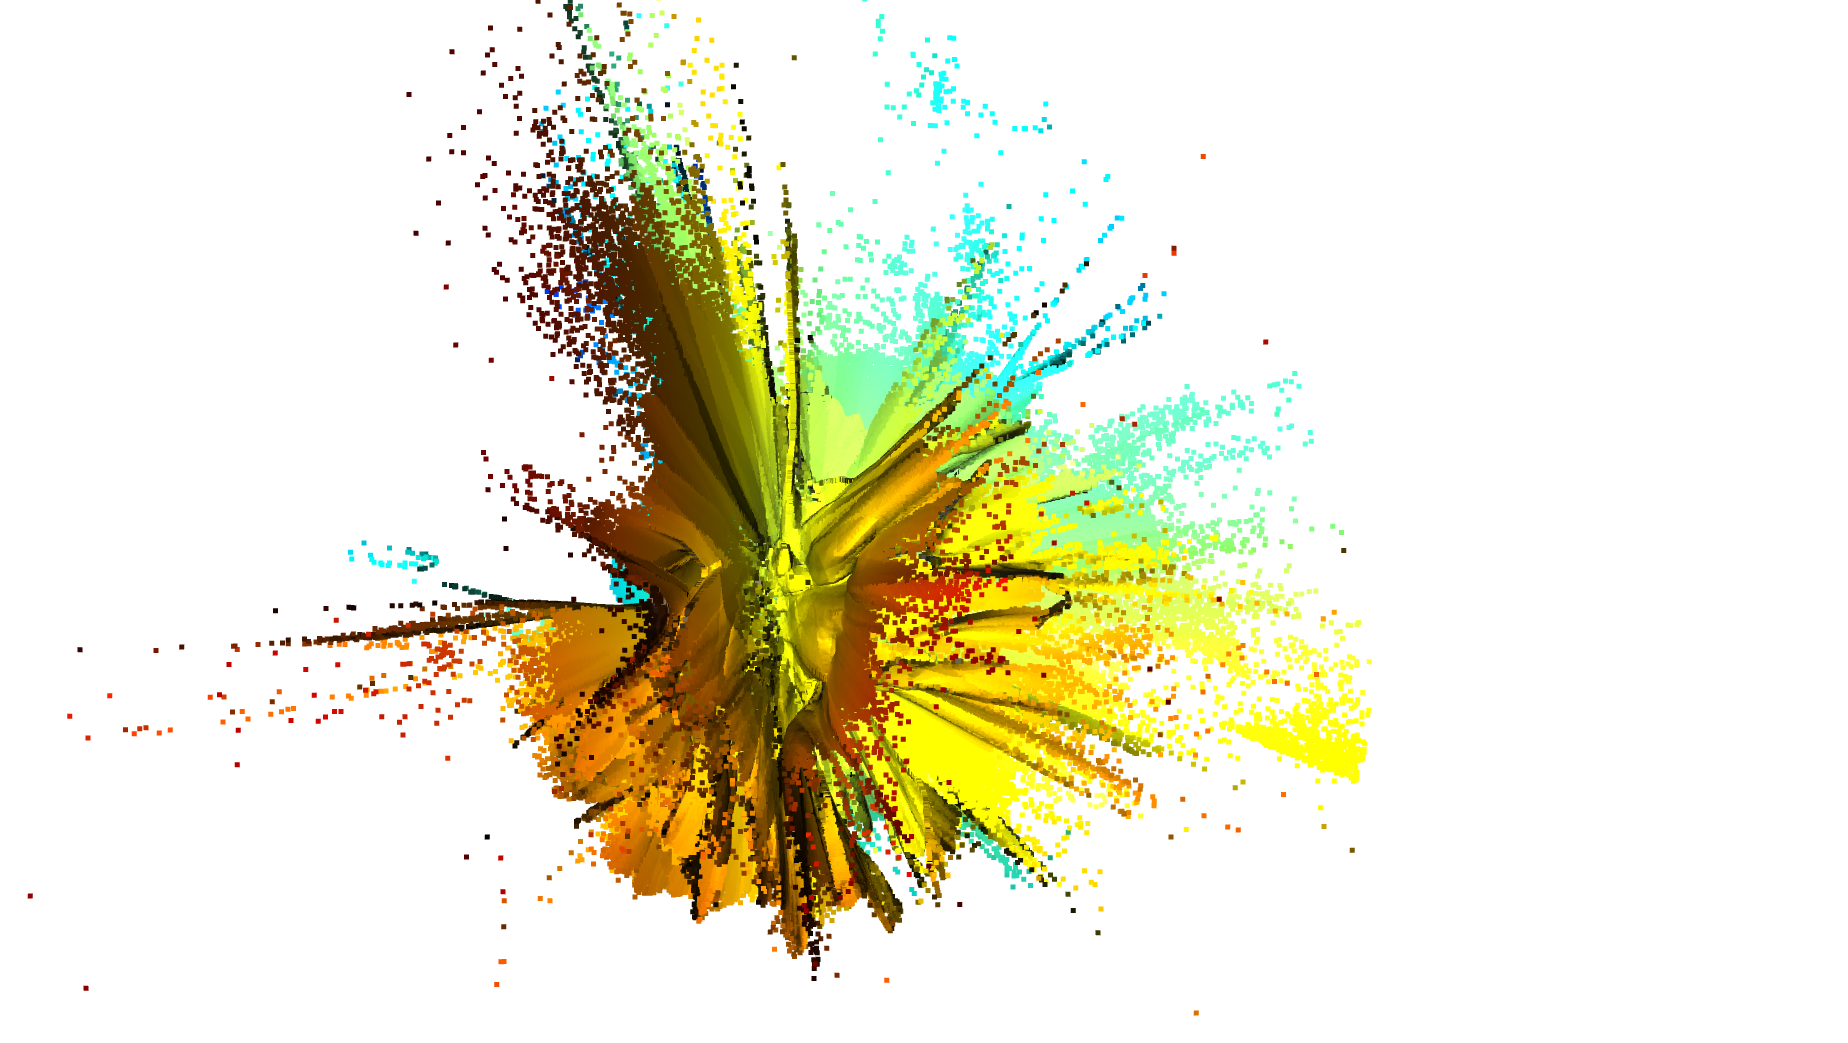

In [255]:
o3d.visualization.draw_geometries([pcd], point_show_normal=False)

In [252]:
poisson_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=8, width=0, scale=1.1, linear_fit=False)[0]

In [242]:
bbox = pcd.get_axis_aligned_bounding_box()
p_mesh_crop = poisson_mesh.crop(bbox)
o3d.io.write_triangle_mesh("/home/reinauer/EPFL/giotto-deep/examples/MNIST_3D/p_mesh_DB_1M.ply", p_mesh_crop)

True

In [256]:
o3d.io.write_point_cloud("/home/reinauer/EPFL/giotto-deep/examples/MNIST_3D/pcld.ply", pcd)

True

In [253]:
def lod_mesh_export(mesh, lods, extension, path):
    mesh_lods={}
    for i in lods:
        mesh_lod = mesh.simplify_quadric_decimation(i)
        o3d.io.write_triangle_mesh(path+"lod_"+str(i)+extension, mesh_lod)
        mesh_lods[i]=mesh_lod
    print("generation of "+str(i)+" LoD successful")
    return mesh_lods
my_lods = lod_mesh_export(poisson_mesh, [100000000], ".ply", "/home/reinauer/EPFL/giotto-deep/examples/MNIST_3D/")

generation of 100000000 LoD successful
